## Project: Behavioral Risk Factors
### Data preprocessing and features selection for cardiovascular health

#### Team Members
Amit Sharma\
Pranav Karmalkar\
Swapnil Parihar

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn import tree
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from matplotlib import pyplot
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_2011 = pd.read_csv('2015.csv')

In [4]:
# Combine all above heart issues in target column:
data_2011["heart_issues"] = data_2011['CVDINFR4']
data_2011[data_2011['heart_issues'] == 1].shape

(25472, 331)

In [5]:
data_2011.heart_issues = np.where(data_2011.CVDCRHD4.eq(1), data_2011.CVDCRHD4, data_2011.heart_issues)
data_2011[data_2011['heart_issues'] == 1].shape

(38633, 331)

In [6]:
data_2011.heart_issues = np.where(data_2011.CVDSTRK3.eq(1), data_2011.CVDSTRK3, data_2011.heart_issues)
data_2011[data_2011['heart_issues'] == 1].shape

(50230, 331)

In [7]:
# Dropping different heart issues columns as all cominded into one column
data_2011 = data_2011.drop(['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3'], axis = 1)

In [8]:
#data_2011['heart_issues'].replace([7, 9], np.nan, inplace=True)

In [9]:
data_2011.dropna(subset=['heart_issues'],inplace=True)

In [10]:
# Converting class 2 to Class 0 for non cardiovascular issues
data_2011['heart_issues'].replace([2], 0, inplace=True)

In [12]:
L = []
for i in data_2011.columns:
    if i.startswith('_'):
        L.append(i)

In [13]:
data_2011.drop(L, axis=1, inplace = True)

In [14]:
test_set = data_2011.loc[data_2011.heart_issues.isin([7,9])]

In [15]:
test_set.shape

(1638, 252)

In [16]:
# Removes all the columns with more than 90% values as Nan values

s = test_set.isnull().apply(sum, axis=0) # count the number of nan in each column
for col in test_set: 
    if s[col] >= 8788:  
        del test_set[col]


In [17]:
# Removes all the columns with zero standard variation in the test set

test_set.drop(test_set.std()[(test_set.std() == 0)].index, axis=1,inplace = True)

In [18]:
test_set.shape

(1638, 244)

In [19]:
#print("\n".join(s for s in test_set.columns if "age" in s.lower()))

In [20]:
#test_set['_IMPAGE'].describe()

In [21]:
training_set = data_2011.loc[~data_2011.heart_issues.isin([7,9])]

In [22]:
training_set.shape

(439818, 252)

In [23]:
# Removes all the columns from the training set not in the training set

difference_list = list(set(training_set.columns) - set(test_set.columns))
training_set.drop(difference_list, axis=1, inplace = True)

In [24]:
training_set.shape

(439818, 244)

In [25]:
# Manually determined list of columns that have pre-existing knowledge of the target column
#training_set.drop(columns = ['QLACTLM2','POORHLTH','DECIDE','DIFFALON'], axis=1, inplace = True)

In [26]:
# Define the target column
training_target = training_set[['heart_issues']]
test_target = test_set[['heart_issues']]

In [27]:
# Remove the target column before performing correlation
training_set.drop(columns=['heart_issues'],inplace=True)
test_set.drop(columns=['heart_issues'],inplace=True)

In [28]:
training_target['heart_issues'].value_counts()

0.0    389588
1.0     50230
Name: heart_issues, dtype: int64

In [29]:
# Remove columns of the type date
training_set = training_set.select_dtypes(exclude=['object'])

In [30]:
training_set.shape

(439818, 236)

In [31]:
#training_set.head()
'''
for i in training_set.columns:
    for row in training_set.index:
        if training_set.loc[row,i] == 0:
            print(i)
            break
'''

'\nfor i in training_set.columns:\n    for row in training_set.index:\n        if training_set.loc[row,i] == 0:\n            print(i)\n            break\n'

In [32]:
# x is used just to generate the required correlation matrix 

x = training_set.fillna(training_set.mode().iloc[0])
#training_set = training_set.fillna(training_set.mode().iloc[0])

In [33]:
corr_matrix = x.corr().abs()

In [34]:
#corr_matrix

In [35]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

In [36]:
len(to_drop)

2

In [37]:
training_set.drop(to_drop, axis=1,inplace = True)

In [38]:
#L = sorted(training_set.columns)
#for i in L:
#    print(i)

In [39]:
training_set.shape

(439818, 234)

In [40]:
#training_set= training_set.dropna(axis='columns')

In [41]:
ss_scaler = preprocessing.StandardScaler()
X_ss = ss_scaler.fit_transform(training_set)

In [42]:
X_ss_df = pd.DataFrame(data=X_ss[0:,0:],    # values
             #index=wine_df_mm[1:,0],    # 1st column as index
             columns=training_set.columns)

In [43]:
model2 = XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_ss_df, training_target,shuffle = True, test_size=0.2, random_state=42)
model2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<BarContainer object of 234 artists>

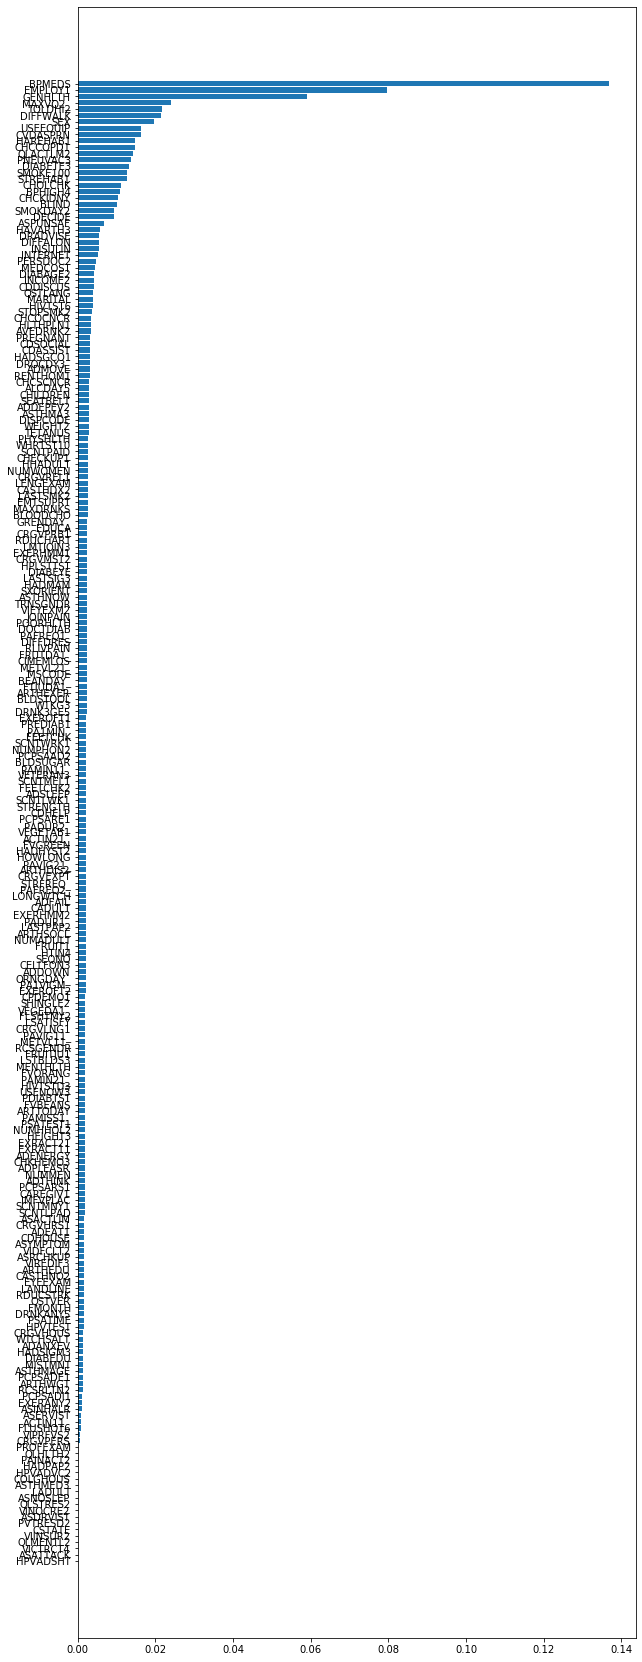

In [44]:
import matplotlib.pyplot as plt
sorted_idx = model2.feature_importances_.argsort()
plt.figure(figsize=(10,30))
plt.barh(training_set.columns[sorted_idx], model2.feature_importances_[sorted_idx])

In [45]:
from sklearn.metrics import classification_report
print("Detailed classification report:")
print()
y_true, y_pred = y_test, model2.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Detailed classification report:

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     77865
         1.0       0.60      0.21      0.31     10099

    accuracy                           0.89     87964
   macro avg       0.75      0.59      0.62     87964
weighted avg       0.87      0.89      0.87     87964




In [46]:
selected = training_set.columns[sorted_idx][-45:]

In [47]:
selected

Index(['DROCDY3_', 'HADSGCO1', 'CDASSIST', 'CDSOCIAL', 'PREGNANT', 'AVEDRNK2',
       'HLTHPLN1', 'CHCOCNCR', 'STOPSMK2', 'HIVTST6', 'MARITAL', 'QSTLANG',
       'CDDISCUS', 'INCOME2', 'DIABAGE2', 'MEDCOST', 'PERSDOC2', 'INTERNET',
       'INSULIN', 'DIFFALON', 'DRADVISE', 'HAVARTH3', 'ASPUNSAF', 'DECIDE',
       'SMOKDAY2', 'BLIND', 'CHCKIDNY', 'BPHIGH4', 'CHOLCHK', 'STREHAB1',
       'SMOKE100', 'DIABETE3', 'PNEUVAC3', 'QLACTLM2', 'CHCCOPD1', 'HAREHAB1',
       'CVDASPRN', 'USEEQUIP', 'SEX', 'DIFFWALK', 'TOLDHI2', 'MAXVO2_',
       'GENHLTH', 'EMPLOY1', 'BPMEDS'],
      dtype='object')

In [53]:
# All selected columns + heart_issues, age and BMI
selected_2015 = ['DROCDY3_', 'HADSGCO1', 'CDASSIST', 'CDSOCIAL', 'PREGNANT', 'AVEDRNK2',
       'HLTHPLN1', 'CHCOCNCR', 'STOPSMK2', 'HIVTST6', 'MARITAL', 'QSTLANG',
       'CDDISCUS', 'INCOME2', 'DIABAGE2', 'MEDCOST', 'PERSDOC2', 'INTERNET',
       'INSULIN', 'DIFFALON', 'DRADVISE', 'HAVARTH3', 'ASPUNSAF', 'DECIDE',
       'SMOKDAY2', 'BLIND', 'CHCKIDNY', 'BPHIGH4', 'CHOLCHK', 'STREHAB1',
       'SMOKE100', 'DIABETE3', 'PNEUVAC3', 'QLACTLM2', 'CHCCOPD1', 'HAREHAB1',
       'CVDASPRN', 'USEEQUIP', 'SEX', 'DIFFWALK', 'TOLDHI2', 'MAXVO2_',
       'GENHLTH', 'EMPLOY1', 'BPMEDS','_AGE_G','_BMI5CAT','heart_issues']

In [50]:
data_2011.drop(data_2011.columns.difference(selected_2015), 1, inplace=True)

In [59]:
data_2011

,GENHLTH,HLTHPLN1,PERSDOC2,MEDCOST,BPHIGH4,BPMEDS,CHOLCHK,TOLDHI2,CHCSCNCR,CHCOCNCR,...,CVDASPRN,ASPUNSAF,HADSGCO1,ADMOVE,QSTLANG,DROCDY3_,MAXVO2_,heart_issues,_AGE_G,_BMI5CAT
0,5.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,1.0,5.397605e-79,2469.0,0.0,5.0,4.0
1,3.0,2.0,1.0,1.0,3.0,NaN,4.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,1.0,5.397605e-79,2876.0,0.0,4.0,3.0
2,4.0,1.0,2.0,2.0,3.0,NaN,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,1.0,9.000000e+02,2173.0,1.0,6.0,2.0
3,5.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,NaN,NaN,2.0,NaN,1.0,5.397605e-79,2469.0,0.0,5.0,3.0
4,5.0,1.0,1.0,2.0,3.0,NaN,1.0,2.0,2.0,2.0,...,NaN,NaN,2.0,NaN,1.0,5.397605e-79,2543.0,0.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,4.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,...,1.0,NaN,NaN,NaN,2.0,5.397605e-79,2136.0,0.0,6.0,1.0
441452,1.0,1.0,1.0,2.0,3.0,NaN,1.0,2.0,2.0,2.0,...,2.0,3.0,NaN,NaN,2.0,5.397605e-79,3727.0,0.0,2.0,3.0
441453,4.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,2.0,7.000000e+00,2210.0,0.0,6.0,4.0
441454,3.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,1.0,NaN,NaN,NaN,2.0,5.397605e-79,3140.0,0.0,4.0,2.0


In [60]:
# Converting results to CSV 
#compression_opts = dict(method='zip',archive_name='CARDIOVASCULAR_2015.csv')  
data_2011.to_csv('CARDIOVASCULAR_2015.csv', index=False) 